In [1]:
from astrometry.util.fits import *
import pylab as plt
from collections import Counter
from astropy.table import Table
from astrometry.util.starutil_numpy import *
from glob import glob
import os
from astrometry.util.util import *

In [2]:
# Dump the copilot database to FITS
T = fits_table('ibis-copilot-db-to-2025-10-20.fits')
len(T)

9367

In [3]:
T.cut(T.mjd_obs > 0)
len(T)

8895

In [4]:
T.mjd_obs.min()

np.float64(60458.79428742)

In [5]:
mjdtodate(T.mjd_obs.min()), mjdtodate(T.mjd_obs.max())

(datetime.datetime(2024, 5, 28, 19, 3, 46, 433077),
 datetime.datetime(2025, 10, 21, 9, 15, 8, 197930))

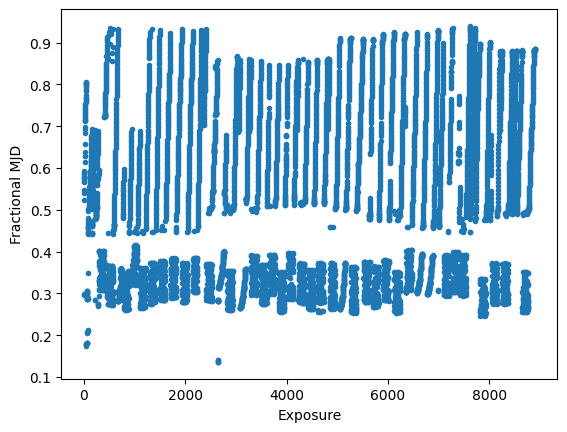

In [6]:
plt.plot(np.fmod(T.mjd_obs - 0.5, 1.0), '.');
plt.xlabel('Exposure')
plt.ylabel('Fractional MJD');

In [7]:
# Cut to medium-band filters
T.cut([f.startswith('M') for f in T.band])
len(T)

5202

In [8]:
Counter(T.obstype)

Counter({np.str_('object'): 3955, np.str_('dome flat'): 1247})

In [9]:
# Cut to normal exposures (not flats)
T.cut(T.obstype == 'object')
len(T)

3955

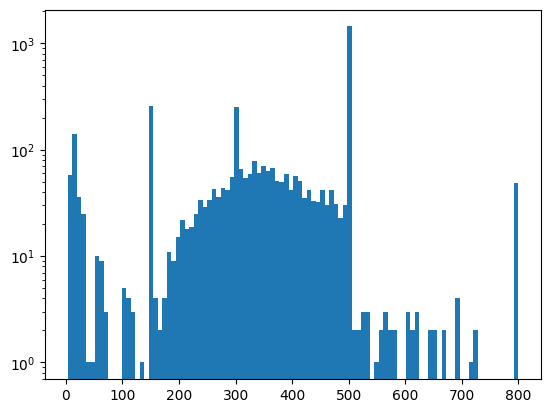

In [10]:
plt.hist(T.exptime, bins=100, log=True);

In [11]:
# Cut various bogus exposures
T.cut(T.exptime >= 100.)
len(T)

3669

In [12]:
T.cut(T.expfactor > 0)
T.speed = 1./T.expfactor
len(T)

3627

In [13]:
T.cut(T.seeing < 3.)
len(T)

3608

In [14]:
T.cut(T.transparency < 1.2)
len(T)

3603

In [15]:
# Keep only the first entry for each expnum.
_,I = np.unique(T.expnum, return_index=True)
T.cut(I)
len(T)

3585

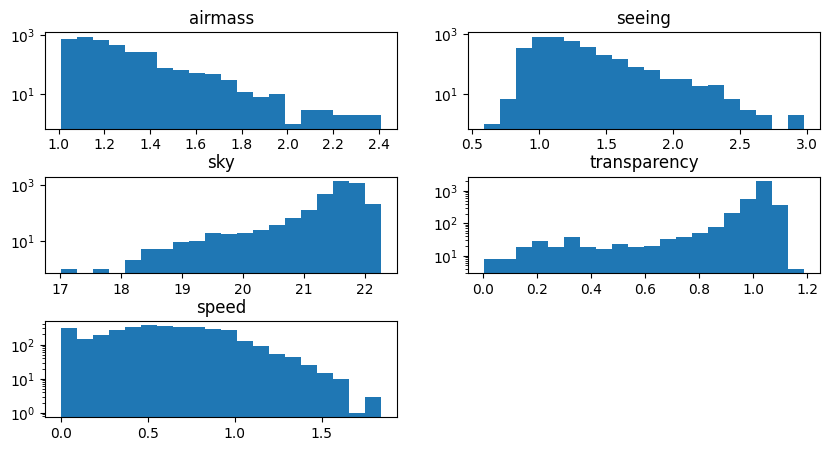

In [16]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(hspace=0.5)
for i,key in enumerate(['airmass', 'seeing', 'sky', 'transparency', 'speed']):
    plt.subplot(3, 2, i+1)
    plt.hist(T.get(key), bins=20, log=True)
    plt.title(key)

In [17]:
Counter(T.band)

Counter({np.str_('M464'): 1293,
         np.str_('M517'): 918,
         np.str_('M490'): 752,
         np.str_('M411'): 356,
         np.str_('M438'): 266})

In [18]:
# RGB Color map
def norm(*c):
    c = np.array(c)
    return np.array([1, 0.8, 1]) * c / np.sum(c)
cc = dict(M411=norm(124/255,0,222/255),
          M438=norm(23/255, 0, 255/255),
          M464=norm(0, 142/255, 255/255),
          M490=norm(0, 255/255, 255/255),
          M517=norm(36/255, 255/255, 0),
         )

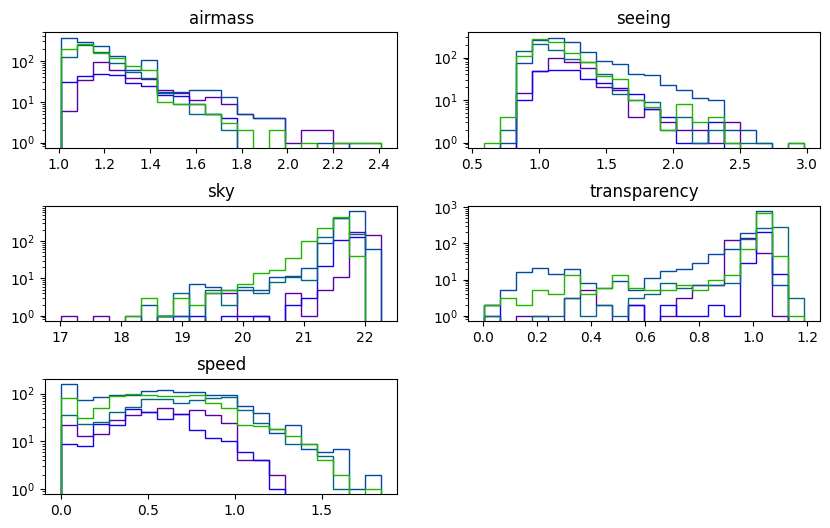

In [19]:
plt.figure(figsize=(10,6))
plt.subplots_adjust(hspace=0.5)

for i,key in enumerate(['airmass', 'seeing', 'sky', 'transparency', 'speed']):
    plt.subplot(3, 2, i+1)
    for b in ['M411', 'M438', 'M464', 'M490', 'M517']:
        I = np.flatnonzero(T.band == b)
        V = T.get(key)
        plt.hist(V[I], bins=20, log=True, range=(V.min(), V.max()), color=cc[b], histtype='step')
    plt.title(key)

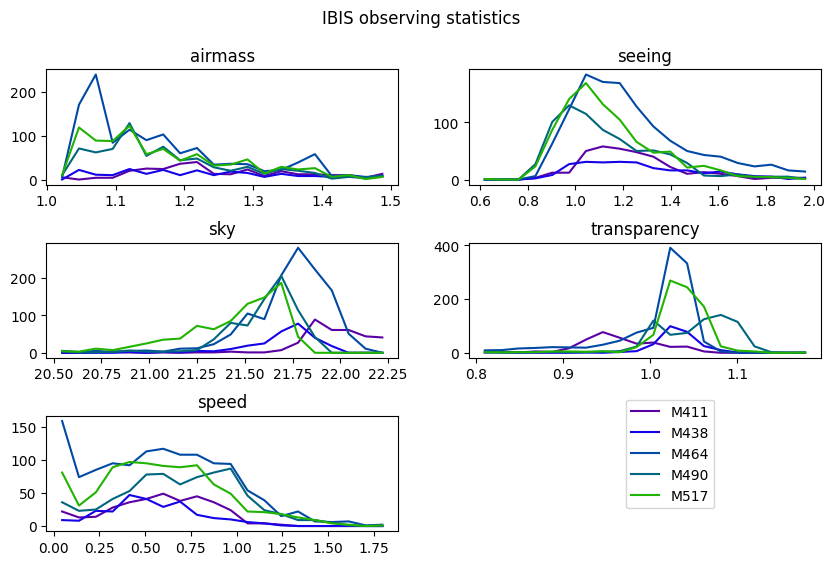

In [20]:
plt.figure(figsize=(10,6))
plt.subplots_adjust(hspace=0.5)
for i,key in enumerate(['airmass', 'seeing', 'sky', 'transparency', 'speed']):
    plt.subplot(3, 2, i+1)
    pp,pl = [],[]
    for b in ['M411', 'M438', 'M464', 'M490', 'M517']:
        I = np.flatnonzero(T.band == b)
        V = T.get(key)
        vmin,vmax = V.min(), V.max()
        if key == 'sky':
            vmin = 20.5
        if key == 'transparency':
            vmin = 0.8
        if key == 'airmass':
            vmax = 1.5
        if key == 'seeing':
            vmax = 2.0
        h,e = np.histogram(V[I], bins=20, range=(vmin, vmax))
        p = plt.plot((e[:-1]+e[1:])/2., h, color=cc[b])
        pp.append(p[0])
        pl.append(b)
    plt.title(key)
plt.figlegend(pp,pl, loc=(0.75,0.1));
plt.suptitle('IBIS observing statistics');
plt.savefig('ibis-stats.png')

In [21]:
np.sum(T.exptime)

np.float32(1.4429139e+06)

In [22]:
np.sum(T.exptime * T.speed)

np.float32(821387.25)

In [23]:
T.mjd_obsday = np.floor(T.mjd_obs - 0.5).astype(int)

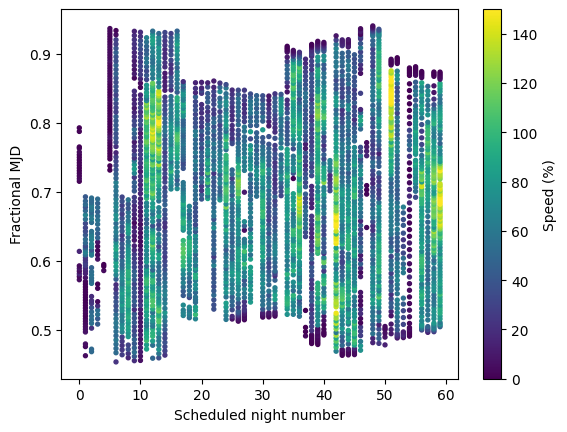

In [41]:
_,day_order = np.unique(T.mjd_obsday, return_inverse=True)
plt.scatter(day_order, np.fmod(T.mjd_obs - 0.5, 1.0), c=T.speed * 100., s=8, vmin=0, vmax=150);
cb = plt.colorbar()
cb.set_label('Speed (%)')
plt.xlabel('Scheduled night number')
plt.ylabel('Fractional MJD');

In [42]:
s = []
for m in T.mjd_obsday:
    d = mjdtodate(m)
    s.append('%i-%02i-%02i' % (d.year, d.month, d.day))
T.mjd_obsday_string = np.array(s)

In [43]:
c = Counter(T.mjd_obsday)
k = list(c.keys())
k.sort()
for kk in k:
    I = np.flatnonzero(T.mjd_obsday == kk)
    d = mjdtodate(kk)
    print('%i-%02i-%02i: %i exposures, exptime %.1f hours, range %.2f days' % (d.year, d.month, d.day, c[kk],
                                                                               np.sum(T.exptime[I])/3600., max(T.mjd_obs[I]) - min(T.mjd_obs[I])))
    #print(T.mjd_obs[I] - kk)

2024-05-28: 23 exposures, exptime 1.8 hours, range 0.22 days
2024-05-30: 49 exposures, exptime 4.5 hours, range 0.23 days
2024-05-31: 36 exposures, exptime 3.5 hours, range 0.22 days
2024-06-02: 23 exposures, exptime 3.0 hours, range 0.18 days
2024-06-04: 3 exposures, exptime 0.2 hours, range 0.01 days
2024-06-05: 52 exposures, exptime 4.4 hours, range 0.20 days
2024-06-06: 79 exposures, exptime 10.6 hours, range 0.48 days
2024-06-29: 43 exposures, exptime 5.2 hours, range 0.23 days
2024-06-30: 47 exposures, exptime 5.0 hours, range 0.23 days
2024-07-02: 76 exposures, exptime 10.5 hours, range 0.48 days
2024-07-03: 77 exposures, exptime 10.7 hours, range 0.47 days
2024-07-05: 97 exposures, exptime 10.0 hours, range 0.45 days
2024-07-06: 108 exposures, exptime 10.0 hours, range 0.47 days
2024-07-08: 101 exposures, exptime 10.3 hours, range 0.47 days
2024-07-09: 75 exposures, exptime 10.3 hours, range 0.47 days
2024-07-11: 41 exposures, exptime 5.1 hours, range 0.23 days
2024-07-12: 45 e

In [44]:
# Omit engineering time
Isched = np.flatnonzero([d not in ['2024-05-28', '2025-04-01', '2025-09-08'] for d in T.mjd_obsday_string])
total_efftime = np.sum(T.exptime[Isched] * T.speed[Isched])
total_exptime = np.sum(T.exptime[Isched])

In [45]:
# The number of scheduled nights: through 2025-10-20.
# 16 half-nights
# 44 full nights
nights = 44 + 16/2
nights

52.0

In [46]:
efftime_per_night = total_efftime / nights
efftime_per_night

np.float32(15760.366)

In [47]:
total_efftime / nights / 3600.

np.float32(4.3778796)

In [48]:
total_exptime / nights / 3600.

np.float32(7.6442323)

In [50]:
tiles = Table.read('ibis-tiles.ecsv')
len(tiles)

61390

In [51]:
Counter(tiles['IN_IBIS'])

Counter({np.int16(1): 58120, np.int16(0): 3270})

In [52]:
tiles = tiles[tiles['IN_IBIS'] == 1]
len(tiles)

58120

In [53]:
Iwide = np.flatnonzero(['wide' in o for o in tiles['OBJECT']])
tiles = tiles[Iwide]
len(tiles)

55560

In [54]:
for filt in np.unique(tiles['FILTER']):
    Ifilt = np.flatnonzero(tiles['FILTER'] == filt)
    efft = np.sum(tiles['EFFTIME_GOAL'][Ifilt])
    print('Filter', filt, 'total efftime %.1f hours -> %.1f scheduled nights' % (efft / 3600., efft / efftime_per_night))

Filter M411 total efftime 1623.4 hours -> 370.8 scheduled nights
Filter M438 total efftime 1314.5 hours -> 300.3 scheduled nights
Filter M464 total efftime 1078.8 hours -> 246.4 scheduled nights
Filter M490 total efftime 1025.4 hours -> 234.2 scheduled nights
Filter M517 total efftime 801.3 hours -> 183.0 scheduled nights


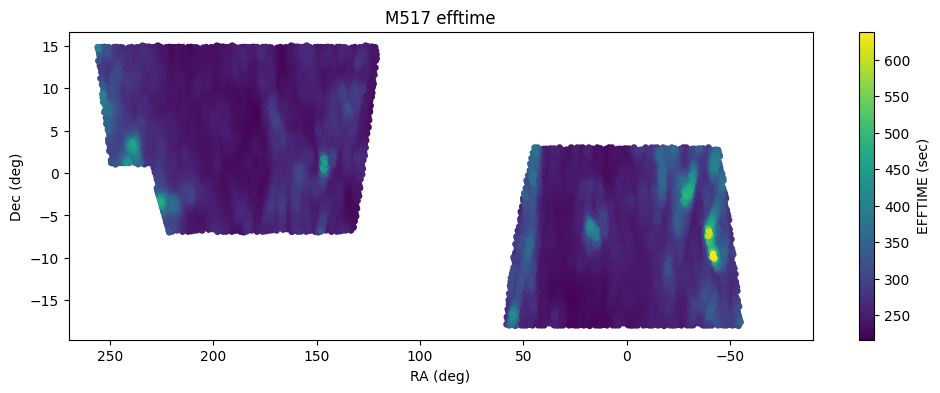

In [80]:
plt.figure(figsize=(12,4))
I = np.flatnonzero(tiles['FILTER'] == 'M517')
I = I[np.argsort(tiles['EFFTIME_GOAL'][I])]
plt.scatter(tiles['RA'][I]
            + -360*(tiles['RA'][I] > 270),
            tiles['DEC'][I], c=tiles['EFFTIME_GOAL'][I], s=15)#, vmin=0);
cb = plt.colorbar()
cb.set_label('EFFTIME (sec)')
plt.title('M517 efftime')
plt.xlim(270, -90);
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)');

In [81]:
nside = 32
T.healpix = np.array([radecdegtohealpix(r,d, nside) for r,d in zip(tiles['RA'], tiles['DEC'])])

In [82]:
sqdeg_sky = 4 * np.pi * np.rad2deg(1.)**2

In [83]:
ibis_sqdeg = len(np.unique(T.healpix)) / (12 * nside**2) * sqdeg_sky
ibis_sqdeg

np.float64(5126.405584949807)

In [84]:
3000 / 5000 * (246 + 234 + 183)

397.8

In [85]:
4200 / 5000 * (246 + 234 + 183)

556.92

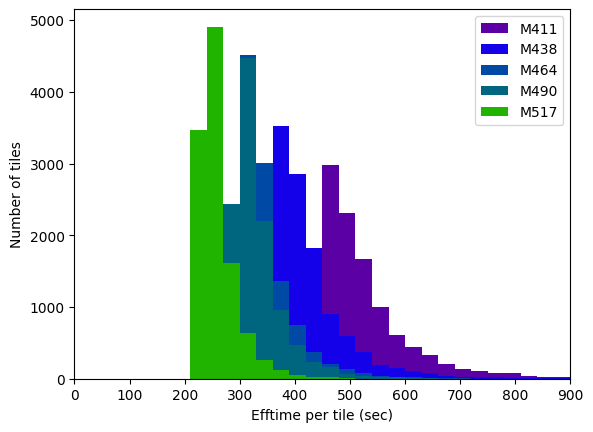

In [86]:
for filt in np.unique(tiles['FILTER']):
    Ifilt = np.flatnonzero(tiles['FILTER'] == filt)
    efft = tiles['EFFTIME_GOAL'][Ifilt]
    plt.hist(efft, color=cc[filt], range=(0,900), bins=30, label=filt)#, histtype='step')
plt.xlim(0,900)
plt.legend()
plt.xlabel('Efftime per tile (sec)')
plt.ylabel('Number of tiles');